# Use a preconditioned convolutional network model

A common and efficient way to do deep learning on small image datasets is to use pre-trained network models.The pre-trained network model is just a network model that has been previously saved after training on a large data set, often with a large image classification task.

If this raw dataset is large enough and universally adequate, then **the level of spatial features learned by trained networks can effectively serve as a universal model for our visual world **and therefore its characteristics prove to be useful for many different computer vision problems , Even though these new questions may involve completely different types from the original ones.

For example, you can train a network on ImageNet, where images are primarily animal and everyday items, and then re-use this well-trained web model to identify the furniture in the image.Compared with many older shallow learning methods, this portability of learning features of different problems is one of the major advantages of deep learning, which makes deep learning very effective for small data image data problems.

## Use VGG16 to pre-train

There are two ways to use pre-trained network models: **feature extraction** and **fine-tuning**.

In [1]:
import platform
import tensorflow
import keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import Image

Using TensorFlow backend.


Platform: Windows-10-10.0.16299-SP0
Tensorflow version: 1.4.0
Keras version: 2.1.2


# Data set description

Kaggle

data set: Dogs vs. Cats [download](https://www.kaggle.com/c/dogs-vs-cats/data)

![dataset](https://imgur.com/0Il4OZF.png)

The original dataset contains images of 25,000 dogs and cats (12,500 per category) and a size of 543MB (compressed). 

After downloading and extracting, we will create a new data set containing three subsets: a set of **Training sets** containing **1000** samples per class, a **Validation set** of **500** samples per set, and the last one containing **500** for each class **Test set** of a sample.
<br><br><br>
### About the data prepare code is in 1.4-small-datasets-image-augmentation###

In [2]:
import os

# ROOT_DIR = os.getcwd()
original_dataset_dir = "D:/Program/dataset/Dogs_vs_Cats"

def create_directory(datapath, subname):
    child_datapath = os.path.join(datapath, subname)
    if not os.path.exists(child_datapath): 
        os.mkdir(child_datapath)
        
    return child_datapath


# Create a directory to store the data set
base_dir = create_directory(original_dataset_dir, "cats_and_dogs_small")

# Training materials directory
train_dir = create_directory(base_dir, 'train')

# Validation data directory
validation_dir = create_directory(base_dir, 'validation')

# Test data directory
test_dir = create_directory(base_dir, 'test')


# Cat's picture of the training information directory
train_cats_dir = create_directory(train_dir, 'cats')

# Dog pictures of training materials directory
train_dogs_dir = create_directory(train_dir, 'dogs')

# Cat's picture of the authentication data directory
validation_cats_dir = create_directory(validation_dir, 'cats')

# Dog's picture verification information directory
validation_dogs_dir = create_directory(validation_dir, 'dogs')

# Cat's picture of the test data directory
test_cats_dir = create_directory(test_dir, 'cats')

# Dog's picture of the test data directory
test_dogs_dir = create_directory(test_dir, 'dogs')

In [3]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


# Feature Extraction

Feature extraction involves the use of pre-trained network models to extract features from new samples. These features pass a "new" classifier (training from scratch).

As mentioned earlier, the convolutional network architecture for image classification consists of two main parts: they start with a series of convolutional and pooling layers and end with a densely-connected classifier. The first part is called the "convolution base" of the model. In a convolutional network, "feature extraction" will simply include "convolution base" of a previously trained network, re-feed new data therethrough, and train one more according to the output of the "convolution base" New classifier.

![feature extraction](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

Why reuse **"convolution base"**? Can we reuse densely-connected classifiers? Generally, it should be avoided. The reason is simply that the features of "convolution base" learning may be more general and therefore more reusable: a convolutional network's feature maps are a mapping of common concepts to images. On the other hand, the features learned by the classifier will be very specific to the set of categories for which the model is trained. They will only contain information about the probability of existence of that class or classes in the whole picture.

In addition, the representations found in densely connected layers no longer contain any information that "space / position" is in the input image: these layers have been freed from the notion of space. For the important and sensitive issue of object location, the functionality of Dense Hierarchy will be largely un-reusable.

Note that the level of generality (and therefore reusability) of representation extracted by a particular convolution layer depends on the depth of the neural layer in the model. **Older layers in the model extract local, highly generic feature maps** (such as visual edges, colors and textures), while higher layers extract more abstract concepts (such as "cat ears" or "dog eyes"). ***So if your new dataset is very different from the dataset your original model was trained on, it's best to use only the first few layers of the model for feature extraction instead of using the entire Convolution Base.***

In our case, it is likely that it would be beneficial to reuse the information contained in the original model's densely populated layer because the ImageNet class collection contains multiple dog and cat classes. However, to cover more generalities, we will not choose to use the original densely-connected layer because the new problem's category set does not overlap with the original model's category set.

Apply the features extracted from our cat and dog images by using the "Convolution Base" of the **VGG16** network trained on ImageNet and then train a cat and dog classifier on top of these features.

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(150, 150, 3)) 

58892288/58889256 [==============================] - 13s 0us/step


* weights: one of None (random initialization) or 'imagenet' (pre-training on ImageNet).
* include_top: whether to include the 3 fully-connected layers at the top of the network.
* input_shape: optional shape tuple, only to be specified if include_top is False

In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________


There are two ways to proceed:

1. Run "Convolution Base" on our dataset, record its output as a Numpy array onto disk, and then use this as input for a densely-connected classifier. This solution is fast and easy because it only requires a "convolution base" that runs once for each input image, and "convolution base" is by far the most expensive part of the pipeline. However, because of the same reason, this practice does not allow us to use the **data augmentation** approach.


2. Extend the model we own (conv_base) by continuing to add the Dense layer to the top of the trained model, and run the entire data input end-to-end across the input. This approach allows us to use **data augmentation** because every time the input image is seen by the model, it passes through the "convolution base." However, this technique takes more computation and training time than the first technique.

### Method 1: Convolution Substrate:Extract features + Concatenate a new dense classification layer: retraining

Record the output of "conv_base" on our data and use these as input for the new model.


In [9]:
%%time
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20 


def extract_features(directory, sample_count): 
    
    # According to the last layer of the VGG16 (convolution base) the turn-out tensor specification
    features = np.zeros(shape=(sample_count, 4, 4, 512)) 
    
    # The number of images to process
    labels = np.zeros(shape=(sample_count)) 
    
    # Produces an "image data generator" instance (the data is in the file directory) and 
    # calls it once, which create specific batch of image data
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),  
        batch_size=batch_size,   
        class_mode='binary')     
    
   
    i = 0
    for inputs_batch, labels_batch in generator:
        # Extract image features through "Convolution Base"
        features_batch = conv_base.predict(inputs_batch)
        # store the feature
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        # store the label
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch 
        i += 1
            
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    
    print('extract_features complete!')
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000) 
validation_features, validation_labels = extract_features(validation_dir, 1000) 
test_features, test_labels = extract_features(test_dir, 1000) 

Found 2000 images belonging to 2 classes.
extract_features complete!
Found 1000 images belonging to 2 classes.
extract_features complete!
Found 1000 images belonging to 2 classes.
extract_features complete!
Wall time: 42.5 s


shape （sample，4，4，512） resize to （sample, 8192）
to connect to the densely-connected Classifier

In [13]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Define our densely-connected classifier (note the use of dropout for normalization) and train the data and labels we just recorded

In [14]:
from keras import models
from keras.layers import Dense, Dropout
from keras import optimizers

model = models.Sequential()
model.add(Dense(256, activation='relu', input_dim=4*4*512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # # Because of my information only two categories (cat & dog) 

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6122 - acc: 0.6635 - val_loss: 0.4522 - val_acc: 0.8290
Epoch 2/30
2000/2000 [==============================] - 1s 672us/step - loss: 0.4339 - acc: 0.8110 - val_loss: 0.3645 - val_acc: 0.8640
Epoch 3/30
2000/2000 [==============================] - 1s 527us/step - loss: 0.3589 - acc: 0.8530 - val_loss: 0.3305 - val_acc: 0.8610
Epoch 4/30
2000/2000 [==============================] - 1s 511us/step - loss: 0.3128 - acc: 0.8815 - val_loss: 0.2986 - val_acc: 0.8800
Epoch 5/30
2000/2000 [==============================] - 1s 567us/step - loss: 0.2873 - acc: 0.8820 - val_loss: 0.2816 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 1s 497us/step - loss: 0.2593 - acc: 0.9015 - val_loss: 0.2843 - val_acc: 0.8800
Epoch 7/30
2000/2000 [==============================] - 1s 504us/step - loss: 0.2498 - acc: 0.9045 - val_loss: 0.2619 - val_acc: 0.8950
Ep

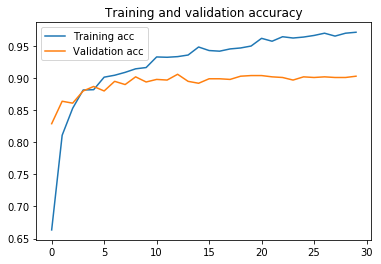

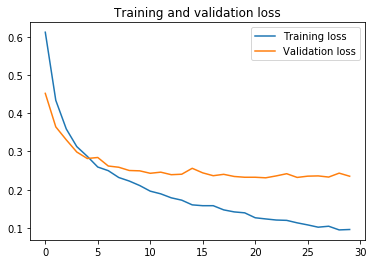

In [15]:
import matplotlib.pyplot as plt

def draw_history(history):

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
draw_history(history)

The validation accuracy rate of about 90%

But, our chart also shows that we were overfitting almost from the very beginning, though we used quite a bit of Dropout.

This is because this technique does not require data expansion (important for preventing overfitting with small image datasets).